In [2]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [5]:
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
ϕ_low, ems_low, _, _ = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

res_list = []
for y_tilde in jump_interval:
    ϕ_list = []
    e_list = []
    for γ3_i in γ3_list[1:]:
        args = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        ϕ, ems, _, _ = solve_smooth_100(y_grid, args, max_iter=5000, tol=1e-7, ϵ=0.5,)
        ϕ_list.append(ϕ)
        e_list.append(ems)
    ϕ_list = np.array(ϕ_list)
    e_list = np.array(e_list)
    res_list.append((ϕ_list, e_list))

episode: 5000,	 ode error: 3.79047342763672e-05,	 ft error: 4.192191606833262e-05
episode: 2563,	 ode error: 0.0003050026779893439,	 ft error: 9.963268965407224e-08
episode: 2783,	 ode error: 0.00126987981738201,	 ft error: 9.980173132362324e-08
episode: 2562,	 ode error: 0.000305649760731469,	 ft error: 9.997995320532027e-08
episode: 2782,	 ode error: 0.0012830526698208045,	 ft error: 9.996664473987948e-08
episode: 2562,	 ode error: 0.00030629526094876763,	 ft error: 9.98617419867287e-08
episode: 2782,	 ode error: 0.0012979659351721662,	 ft error: 9.966808178774045e-08
episode: 2562,	 ode error: 0.00030694026075523545,	 ft error: 9.973930392703778e-08
episode: 2782,	 ode error: 0.0013148999865644061,	 ft error: 9.952389845580001e-08
episode: 2562,	 ode error: 0.00030758606903933533,	 ft error: 9.962861469148265e-08
episode: 2784,	 ode error: 0.0013342024223619532,	 ft error: 9.983494209109267e-08
episode: 2561,	 ode error: 0.00030823350471859134,	 ft error: 9.999516770164973e-08
episo

In [6]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)
ϕ_ref = np.zeros((3, len(pre_jump)))
ems_ref = np.zeros((3, len(pre_jump)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = ϕ_low[i+len(prepre_jump)]
    ϕ_ref[1:, i + len(prepre_jump)] = res_list[i][0][:, i + len(prepre_jump)]
    ems_ref[0, i + len(prepre_jump)] = ems_low[i + len(prepre_jump)]
    ems_ref[1:, i + len(prepre_jump)] = res_list[i][1][:, i + len(prepre_jump)]

In [7]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

In [9]:
τ = 1
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.25

In [10]:
float(ans[-1])**4 -1

-0.9126219746158473

In [11]:
r0, r1

(-0.25, -19.5000916299522)

In [12]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [13]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2
ϕ_list = np.array([ϕ_low, res_list[-1][0][0], res_list[-1][0][1]])

ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-7
ϵ = 0.25
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
#     g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    - ξp*intensity*(weighted - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems)

episode: 4000,	 ode error: 0.0014285380170553363,	 ft error: 0.0001228039862781749


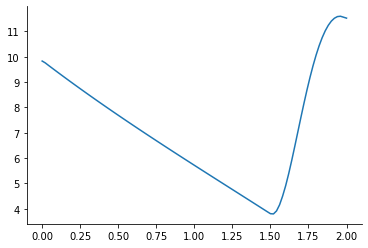

In [14]:
plt.plot(y_grid_cap,ems)

In [15]:
def no_jump_simulation():
    y = 1.1
    T = 80
    dt = 1
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
        e_i = np.interp(y, y_grid_cap, ems)
        prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    return et, yt, probt

In [64]:
et, yt, probt = no_jump_simulation()

In [66]:
et[60-1]

4.657091965287205

(0.0, 1.0091000613095158)

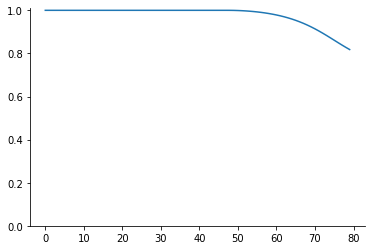

In [17]:
T = 80
# year = np.arange(0, T-τ, τ)
plt.plot(probt)
plt.ylim(0)

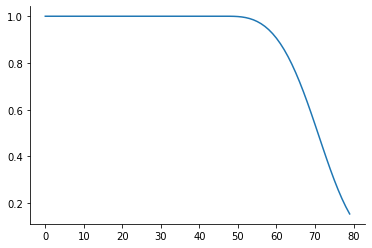

In [18]:
instensity = 1 - probt
integral = np.cumsum(instensity)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [19]:
prob_no_jump = np.cumprod(probt)

(1.0, 2.0)

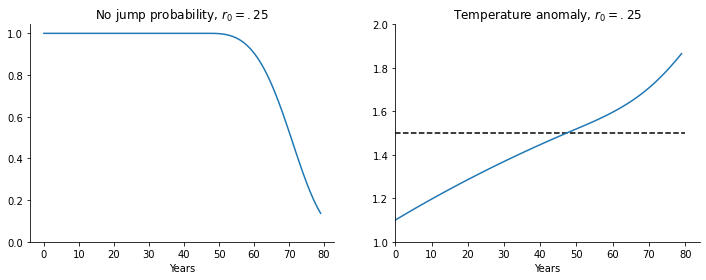

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(prob_no_jump)
ax1.set_title("No jump probability, $r_0 = .25$")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
# plt.savefig('no_jump_prob.pdf')

ax2.plot(yt)
ax2.hlines(1.5, 0, 80, color="black", linestyle="dashed")
ax2.set_xlim(0)
ax2.set_title('Temperature anomaly, $r_0 =  .25$')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
# plt.savefig('r0_2.pdf')

In [27]:
prob_no_jump[70]

0.5280711724509188

(1.0, 2.0)

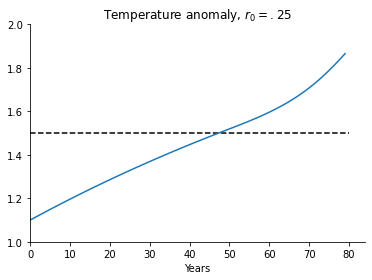

In [29]:
plt.plot(yt)
plt.hlines(1.5, 0, 80, color="black", linestyle="dashed")
plt.xlim(0)
plt.title('Temperature anomaly, $r_0 =  .25$')
plt.xlabel('Years')
plt.ylim(1,2)
# plt.savefig('Yt.pdf')

(0.0, 11.445801076510383)

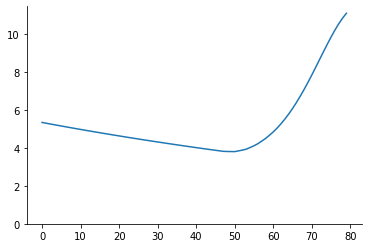

In [30]:
plt.plot(et)
plt.ylim(0)

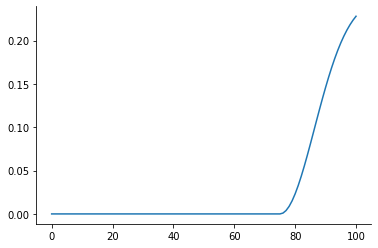

In [31]:
plt.plot(intensity)

In [73]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and y <= y_bar:
#             print(t)
            if jumped == False:
                intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
                jump = np.random.binomial(1, intensity_i)
                if jump == 1:
                    jumped = True
                    dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                    if np.array_equal(dmg_realization, np.array([1, 0, 0])):
                        ems_grid_realize = ems_ref[0]
                        state_t[t] = 1
                    elif np.array_equal(dmg_realization, np.array([0, 1, 0])):
                        ems_grid_realize = ems_ref[1]
                        state_t[t] = 2
                    else:
                        ems_grid_realize = ems_ref[2]
                        state_t[t] = 3
                    et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                elif jump == 0:
                    et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                    state_t[t] = 0
            elif jumped  == True:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [80]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T=86, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [81]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list))

In [86]:
np.unique(Et[:,70]).shape

(70,)

In [87]:
e_select = Et[np.where(Statet[:, 60]==2), 80]

(array([5.36548416e-04, 0.00000000e+00, 3.69271557e-03, 0.00000000e+00,
        0.00000000e+00, 9.31069309e-03, 0.00000000e+00, 0.00000000e+00,
        1.73589193e-02, 0.00000000e+00, 2.91945461e-02, 0.00000000e+00,
        0.00000000e+00, 4.19770231e-02, 0.00000000e+00, 5.94621891e-02,
        0.00000000e+00, 7.70736018e-02, 9.77464967e-02, 6.63647267e-01]),
 array([4.39809283, 4.39826561, 4.3984384 , 4.39861118, 4.39878396,
        4.39895674, 4.39912953, 4.39930231, 4.39947509, 4.39964787,
        4.39982066, 4.39999344, 4.40016622, 4.400339  , 4.40051179,
        4.40068457, 4.40085735, 4.40103013, 4.40120292, 4.4013757 ,
        4.40154848]),
 <BarContainer object of 20 artists>)

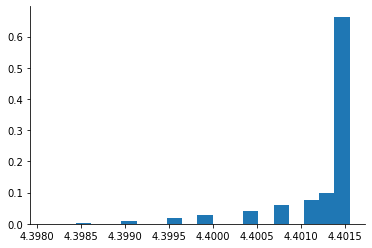

In [88]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [61]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

Text(0.5, 1.0, 'Emission')

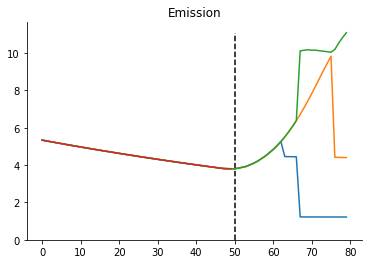

In [62]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')